In [136]:
import numpy as np

In [137]:
K = 3 # Number of clusters
M = 2 # Observation dimension

In [138]:
np.random.seed(6)

mus = np.random.randn(K, M) * 2
sigmas = np.random.randn(K, M, M)
sigmas = sigmas @ sigmas.transpose(0, 2, 1) + np.expand_dims(np.eye(M), 0)

In [139]:
mus, sigmas

(array([[-0.62356735,  1.45800785],
        [ 0.43564158, -1.79818359],
        [-4.9735613 ,  1.82650304]]),
 array([[[ 4.56275095,  2.49848451],
         [ 2.49848451,  3.87208376]],
 
        [[ 8.28582739, -0.13890059],
         [-0.13890059,  2.64481143]],
 
        [[ 1.02902951, -0.01157507],
         [-0.01157507,  1.02986016]]]))

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

In [141]:
from scipy.stats import multivariate_normal

In [143]:
def plot_mvn(mu, sigma, xlims, ylims):
    
    to_eval = np.meshgrid(np.linspace(xlims[0], xlims[1], 100), np.linspace(ylims[0], ylims[1], 100))

    stacked = np.stack([to_eval[0].reshape(-1), to_eval[1].reshape(-1)], axis=1)
    
    sample_mvn = multivariate_normal(mean=mu, cov=sigma)
    
    prob = sample_mvn.pdf(stacked)
    reshaped_prob = np.reshape(prob, (100, 100))
    
    return to_eval[0], to_eval[1], reshaped_prob

In [144]:
# Let's draw some samples from these:
props = np.random.uniform(0, 1, size=K)
props /= np.sum(props)

props

array([0.35688364, 0.32762544, 0.31549091])

In [145]:
N = 1000

# Now let's sample some data
indicators = np.random.choice(np.arange(K), p=props, size=N)

clus_means = mus[indicators]
clus_sigmas = sigmas[indicators]

draws = np.stack([np.random.multivariate_normal(x, y) for x, y in zip(clus_means, clus_sigmas)])

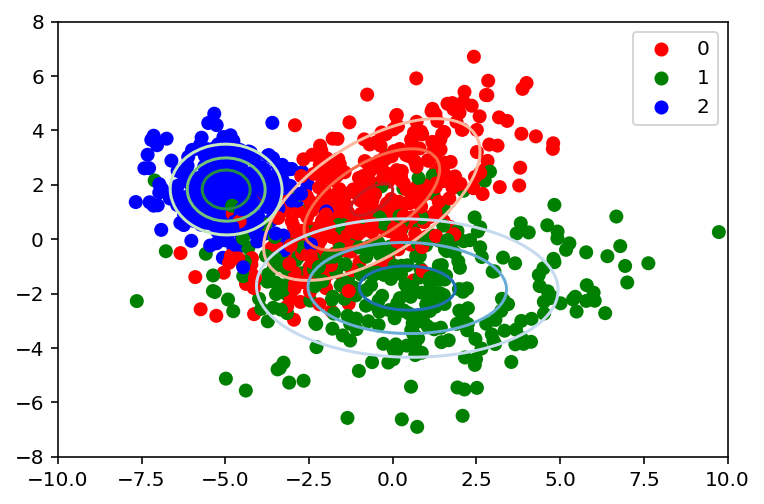

In [146]:
# Draw the data with "true" labels

cmaps = ['Reds', 'Blues', 'Greens']
cols = ['r', 'g', 'b']

xlims = (-10, 10)
ylims = (-8, 8)

for i, (cur_mean, cur_sigma, cur_cmap, cur_col) in enumerate(zip(mus, sigmas, cmaps, cols)):
    
    cur_x, cur_y, cur_probs = plot_mvn(cur_mean, cur_sigma, xlims, ylims)
    
    plt.scatter(cur_mean[0], cur_mean[1], color=cur_col)
    plt.contour(cur_x, cur_y, cur_probs, 3, cmap=cur_cmap)
    
plt.legend([f'{i}' for i in range(mus.shape[0])])
plt.scatter(draws[:, 0], draws[:, 1], c=np.array(cols)[indicators])

In [159]:
# Initialise variables for EM (just randomly)
em_mus = np.random.randn(K, M) * 4
em_sigmas = np.random.randn(K, M, M)
em_sigmas = em_sigmas @ em_sigmas.transpose(0, 2, 1) + np.expand_dims(np.eye(M), 0)
em_log_pi = np.log(np.repeat(1 / K, K))

In [160]:
from mvn_mix_em import e_step

# Code to plot the current setup
def plot_em(em_mus, em_sigmas, em_log_pi, data, ax, 
            xlims=(-10, 10), ylims=(-8, 8)):
    
    cmaps = ['Reds', 'Greens', 'Blues']
    cols = ['r', 'g', 'b']
    log_gamma = e_step(em_mus, em_sigmas, em_log_pi, data)
    gamma = np.exp(log_gamma)

    for i, (cur_mean, cur_sigma, cur_cmap, cur_col) in enumerate(
            zip(em_mus, em_sigmas, cmaps, cols)):

        cur_x, cur_y, cur_probs = plot_mvn(
            cur_mean, cur_sigma, xlims, ylims)

        ax.scatter(cur_mean[0], cur_mean[1], color=cur_col)
        ax.contour(cur_x, cur_y, cur_probs, 3, cmap=cur_cmap)

    ax.legend([f'{i}' for i in range(mus.shape[0])])
    ax.scatter(data[:, 0], data[:, 1], c=gamma.T)
    
    plt.axis("off")
    plt.axis('image')
    
    return ax

In [161]:
from mvn_mix_em import fit_em

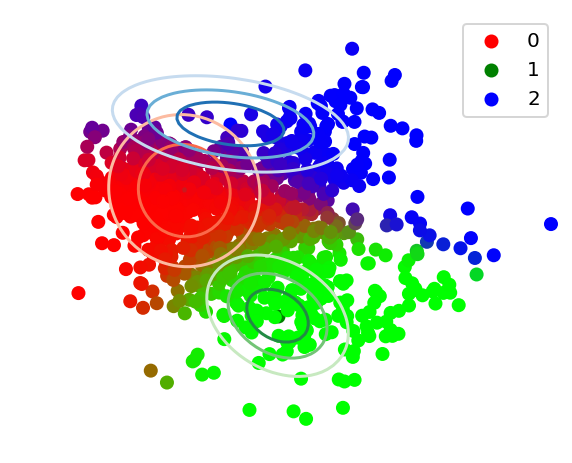

In [162]:
f, ax = plt.subplots(1, 1)

# Initialisation:
plot_em(em_mus, em_sigmas, em_log_pi, draws, ax)
#plot_em(em_mus, em_sigmas, em_log_pi, draws, ax)

In [163]:
from os import makedirs

makedirs('./individual_images/', exist_ok=True)

def plot_callback(iteration, em_mus, em_sigmas, em_log_pi, log_liks):
    
    f, ax = plt.subplots(1, 1)
    
    plot_em(em_mus, em_sigmas, em_log_pi, draws, ax=ax)
    
    f.tight_layout()
    
    plt.savefig(f'./individual_images/iteration_{iteration:04d}.png', dpi=150)
    
    plt.close(f)

In [164]:
# To draw pictures, call:
# opt_mus, opt_sigmas, opt_log_pi, log_liks = fit_em(em_mus, em_sigmas, em_log_pi, draws, callback=plot_callback)

# Otherwise:
opt_mus, opt_sigmas, opt_log_pi, log_liks = fit_em(em_mus, em_sigmas, em_log_pi, draws)

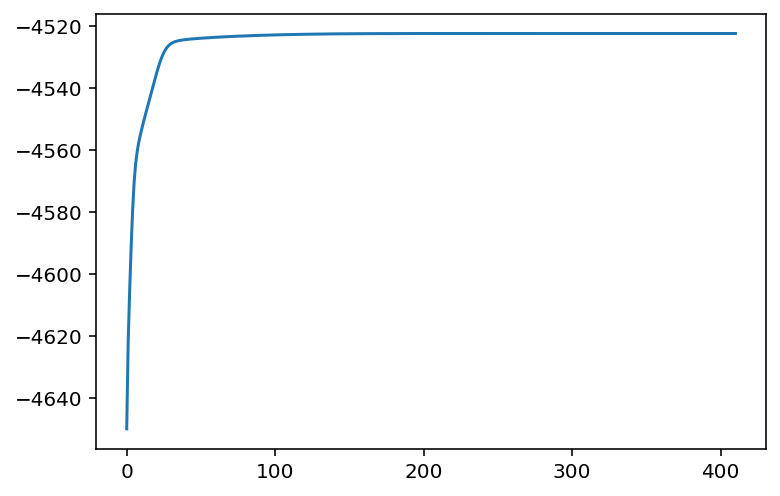

In [165]:
plt.plot(log_liks)

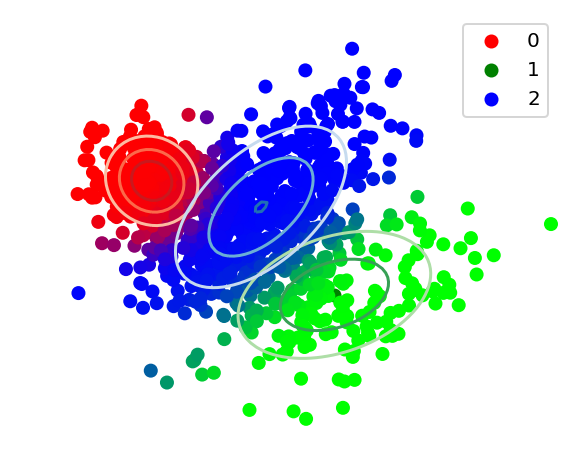

In [166]:
# Final fit
f, ax = plt.subplots(1, 1)

plot_em(opt_mus, opt_sigmas, opt_log_pi, draws, ax)